In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 30]

In [1]:
import fastai as fai
from fastai.basic_data import DataLoader
from data_loader import *
import numpy as np
from torch.utils.data import SubsetRandomSampler
from model import *
from model_bn import *
from torch import optim
import dill
import papermill as pm
from main import *
import seaborn as sns
import pandas as pd

In [2]:
optimizer = 'Adam'
num_workers=8
maxsize=100000
batch_size=2048
n_epochs=500
batch_norm = True
dataset='data/speedup_dataset.h5'

In [3]:
train_dl, val_dl = train_dev_split(dataset, batch_size, num_workers, maxsize)

db = fai.basic_data.DataBunch(train_dl, val_dl)

In [4]:
def criterion(inputs, targets):
    eps = 1e-5
    return torch.mean(torch.abs(targets - inputs)/(targets+eps)*100)

In [5]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]

layers_sizes = [300, 200, 120, 80, 30]

model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes)
else:
    model = Model(input_size, output_size)
    
#criterion = nn.MSELoss()

l = fai.Learner(db, model, loss_func=criterion)

if optimizer == 'SGD':
    l.opt_func = optim.SGD


In [44]:
print(l.model)

Model_BN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=381, out_features=300, bias=False)
    (1): Linear(in_features=300, out_features=200, bias=False)
    (2): Linear(in_features=200, out_features=120, bias=False)
    (3): Linear(in_features=120, out_features=80, bias=False)
    (4): Linear(in_features=80, out_features=30, bias=False)
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (predict): Linear(in_features=30, out_features=1, bias=True)
)


In [116]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


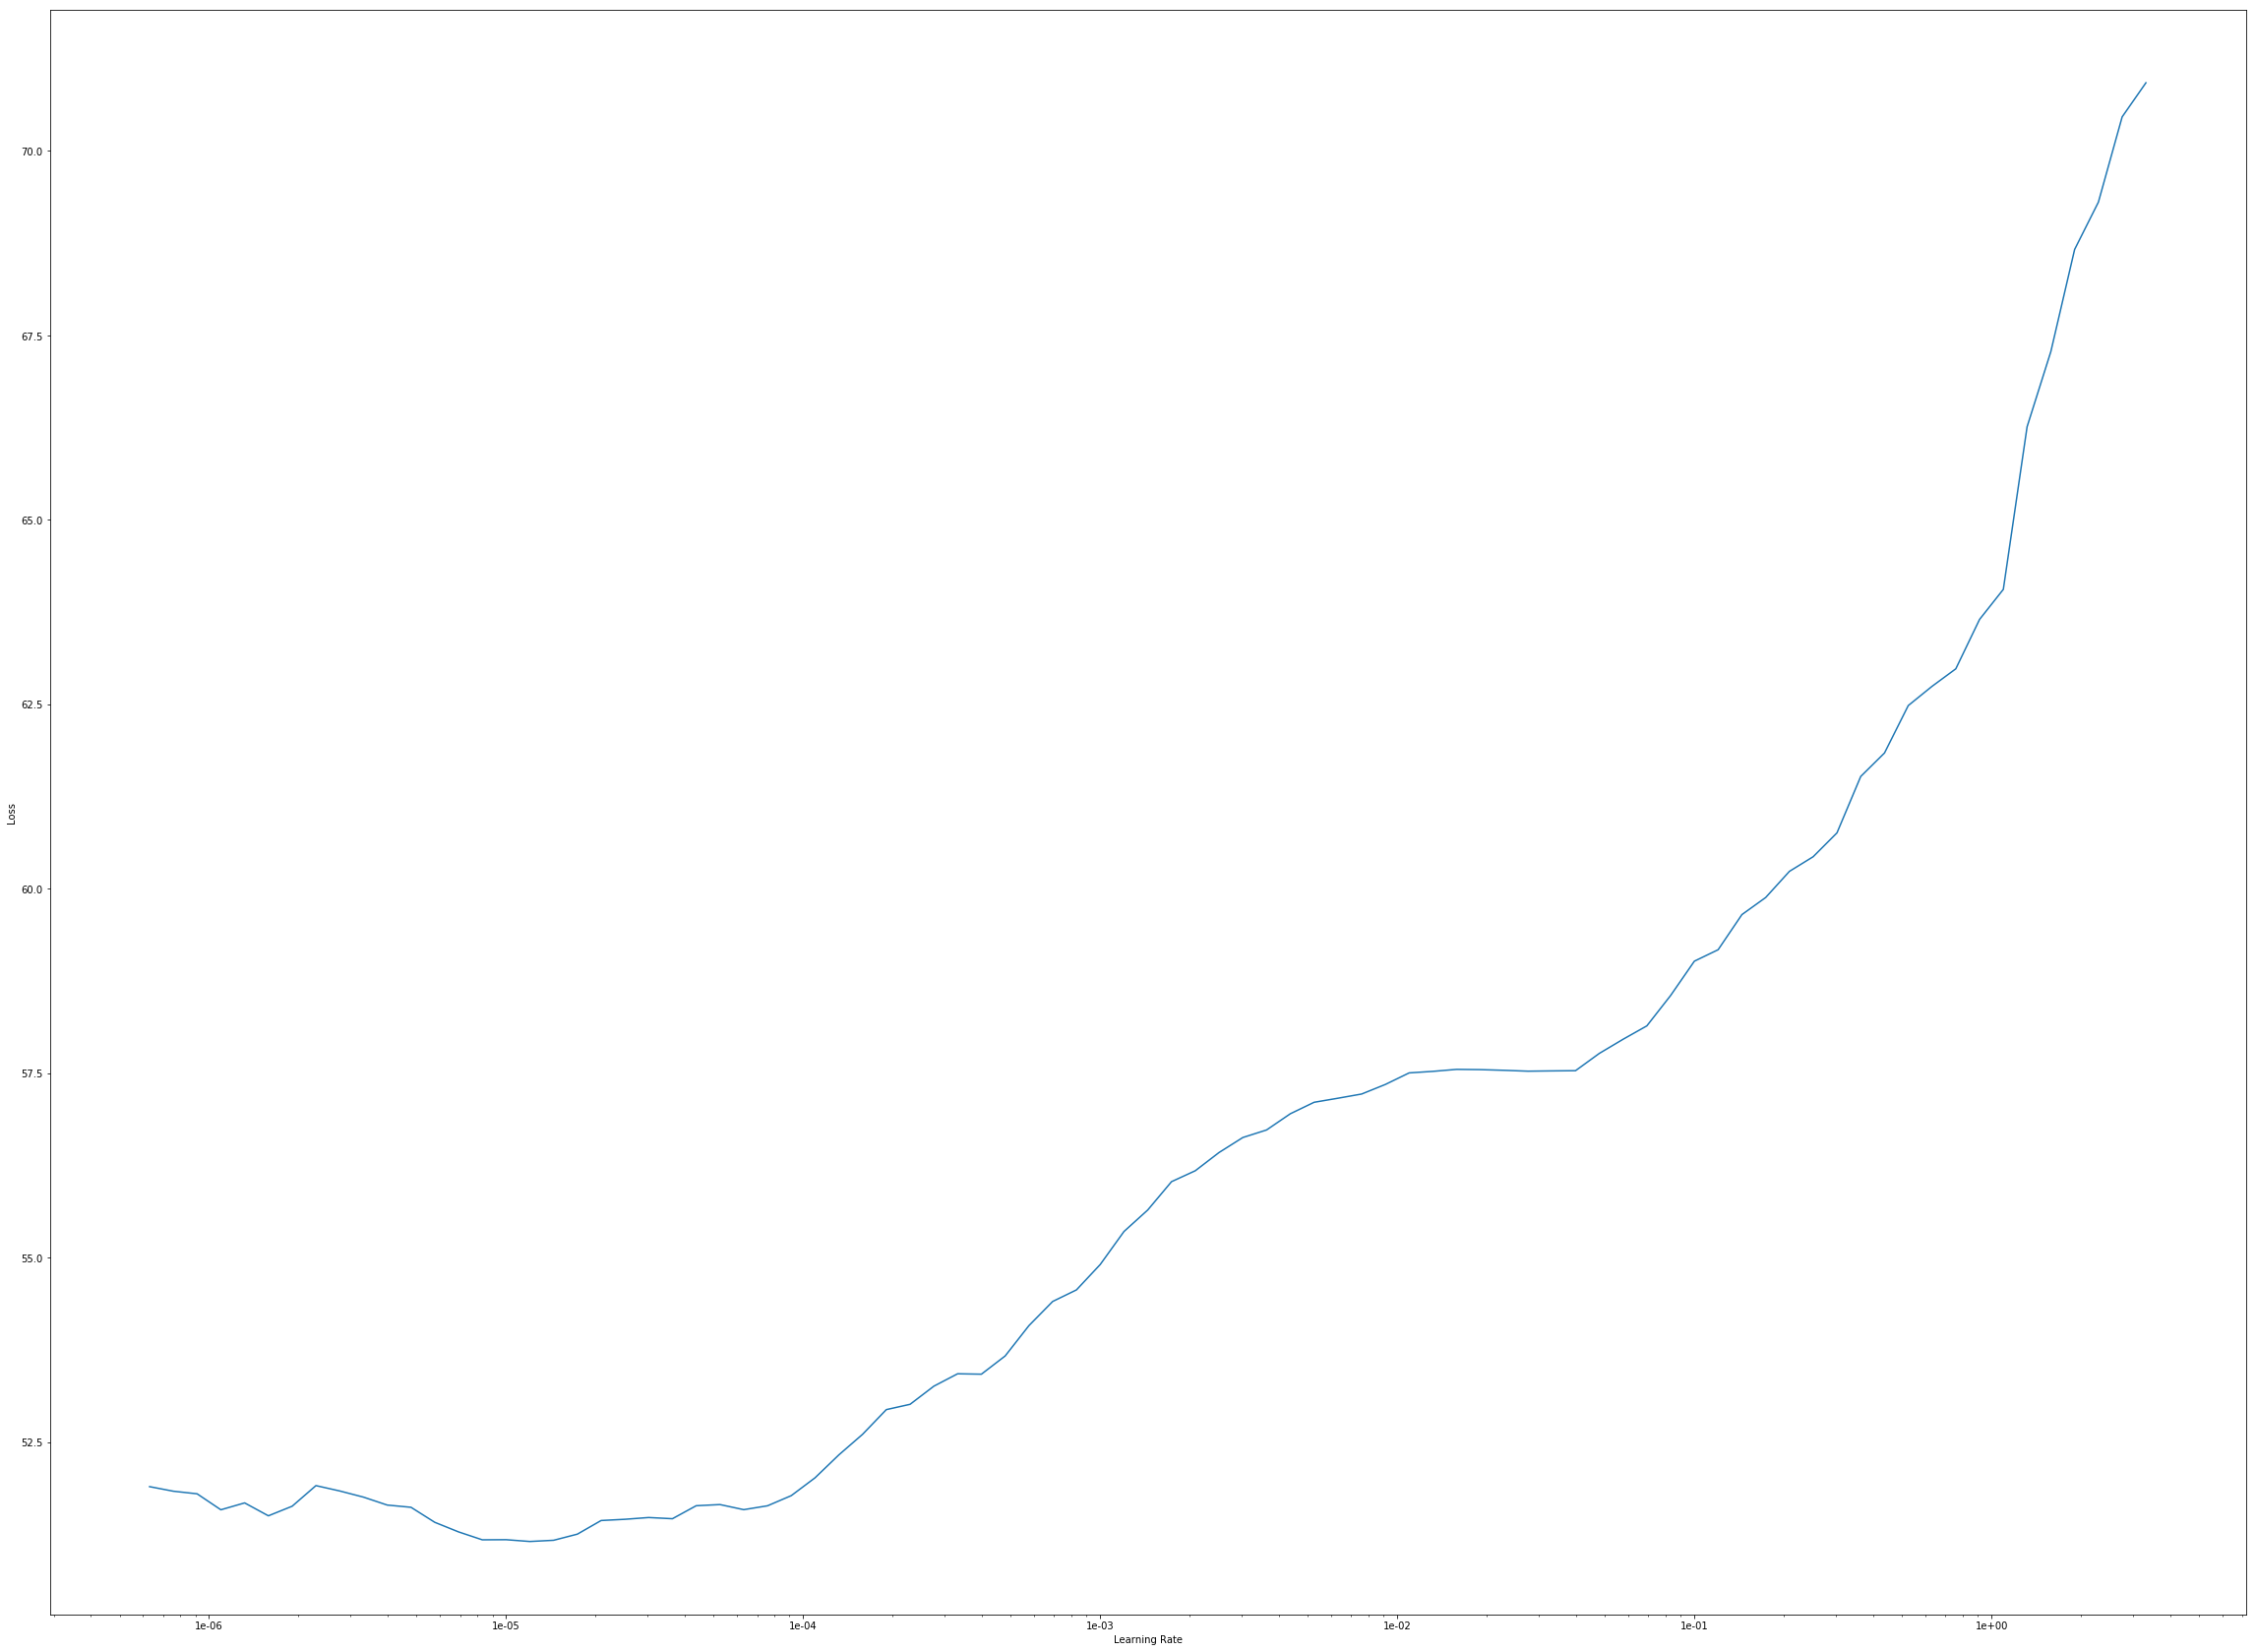

In [117]:
l.recorder.plot()

In [136]:
lr =1e-5

In [137]:
l.fit_one_cycle(1200, lr)

epoch,train_loss,valid_loss
1,43.308823,42.511745
2,43.440548,42.512672
3,43.522625,42.832088
4,43.359398,42.508614
5,43.424362,42.823555
6,43.302296,42.570656
7,43.337223,42.466236
8,43.198784,42.481415
9,43.276703,42.472767
10,43.393902,42.904263


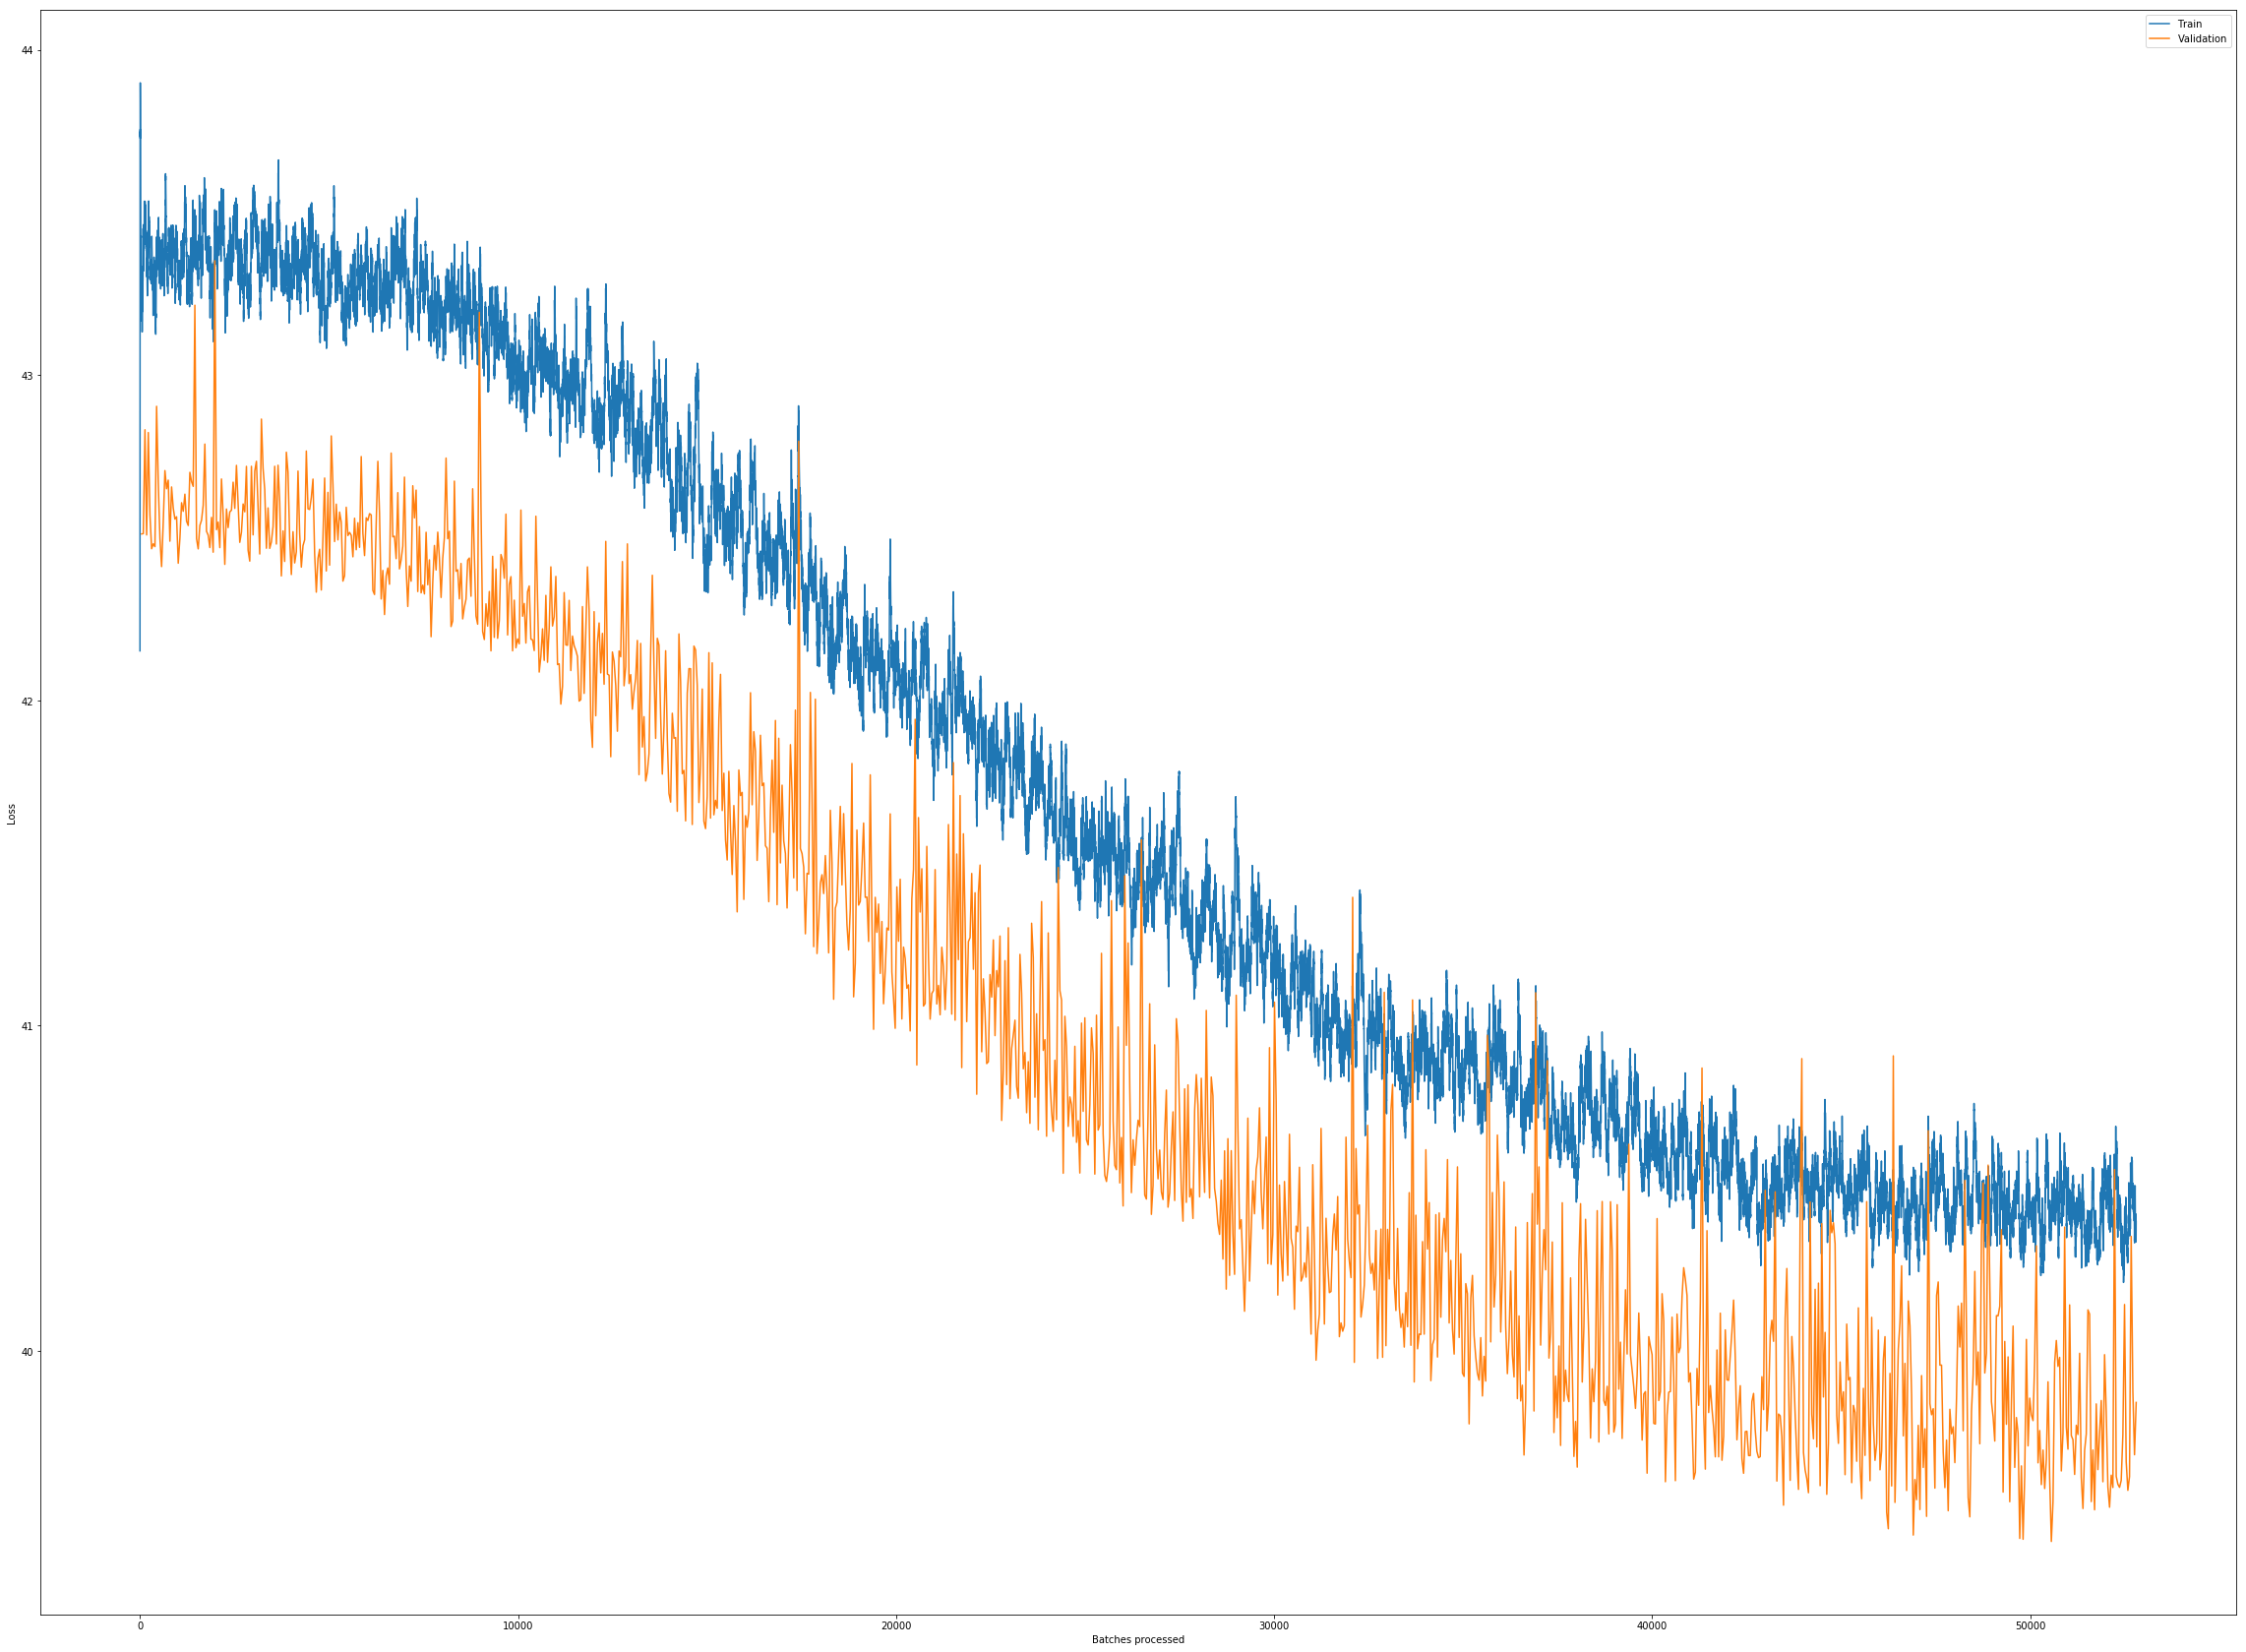

In [139]:
l.recorder.plot_losses()

In [135]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_mse_nlayers_{len(layers_sizes)}")

In [6]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_mse_nlayers_{len(layers_sizes)}") 

In [7]:
val_df = pd.DataFrame()
train_df = pd.DataFrame()

preds, targets = l.get_preds(fai.basic_data.DatasetType.Valid)

preds = preds.reshape((-1,)).numpy()
targets = targets.reshape((-1,)).numpy()

val_df['pred'] = preds
val_df['target'] = targets
val_df['abs_diff'] = np.abs(preds - targets)
val_df['APE'] = np.abs(val_df.target - val_df.pred)/val_df.target * 100

preds, targets = l.get_preds(fai.basic_data.DatasetType.Train)

preds = preds.reshape((-1,)).numpy()
targets = targets.reshape((-1,)).numpy()

train_df['pred'] = preds
train_df['target'] = targets
train_df['abs_diff'] = np.abs(preds - targets)
train_df['APE'] = np.abs(train_df.target - train_df.pred)/train_df.target * 100

In [105]:
train_df.describe()

,pred,target,abs_diff,APE
count,90000.000000,90000.000000,90000.000000,90000.000000
mean,1.941154,2.031324,0.684319,61.384346
std,1.609805,1.925734,0.753625,107.120293
min,-0.157797,0.028617,0.000011,0.000544
25%,0.742593,0.649040,0.180828,14.958478
50%,1.470519,1.396559,0.429848,32.670835
75%,2.753879,2.621620,0.925115,61.996639
max,10.633808,13.560771,8.974062,2388.007812


In [100]:
train_df.describe()

,pred,target,abs_diff,APE
count,90000.000000,90000.000000,90000.000000,90000.000000
mean,1.955619,2.031322,0.686646,65.346382
std,1.562531,1.925733,0.743749,118.350204
min,-0.145053,0.028617,0.000002,0.000185
25%,0.790863,0.649040,0.187947,15.021752
50%,1.513035,1.396559,0.444722,32.155708
75%,2.789342,2.621620,0.923823,63.015770
max,10.399451,13.560771,8.745758,2802.083008


In [134]:
val_df.describe()

,pred,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.502686,2.019351,0.763961,42.495895
std,1.421925,1.923597,0.926997,36.887840
min,-0.139572,0.031008,0.000083,0.007530
25%,0.433389,0.645243,0.150516,17.843959
50%,0.992827,1.387672,0.426106,35.945587
75%,2.151397,2.617450,1.029043,60.084542
max,8.528646,13.558847,7.275390,654.606445


In [101]:
val_df.describe()

,pred,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.959154,2.019354,0.676217,65.818283
std,1.570999,1.923599,0.731138,122.390106
min,-0.089540,0.031008,0.000007,0.000882
25%,0.777360,0.645243,0.177962,14.538821
50%,1.504867,1.387672,0.436823,31.890802
75%,2.792107,2.617450,0.914852,64.005240
max,10.399451,13.558847,6.138021,2274.407227


In [ ]:
sns.jointplot()